In [ ]:
## To access Global Flood Database Data, run:
# gsutil -m cp -r gs://gfd_v1_4 "your\local\repository"
## Install gsutil first: https://cloud.google.com/storage/docs/gsutil_install
## GFD repo is available at: https://github.com/cloudtostreet/MODIS_GlobalFloodDatabase

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

PATH = "Z:\Laboral\World Bank\CLIENT v2"
DATA_RAW = rf"{PATH}\Data\Data_raw"
DATA_PROC = rf"{PATH}\Data\Data_proc"
DATA_OUT = rf"{PATH}\Data\Data_out"

era5 = xr.open_dataset(rf"{DATA_OUT}\ERA5_monthly_1970-2021_SPI-SPEI.nc")

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
WB_country_path = rf"{DATA_PROC}\WB_country_grid.nc"
WB_country_grid = xr.open_dataset(WB_country_path, chunks={"x": 100, "y": 100})

In [3]:
era5 = era5.rename({"latitude": "y", "longitude": "x"})

In [ ]:
era5 = era5.isel(time=30)
# Regrid era5 to make it go from -180 to 180
era5 = era5.assign_coords(x=(((era5.x + 180) % 360) - 180)).sortby('x')
# .sel(x=slice(-70+180, -60+180), y=slice(-30, -45))

In [6]:
# Select Argentina
spei3 = era5.sel(x=slice(-70, -60), y=slice(-30, -45))["SPEI-3"].load()
adm2 = WB_country_grid.sel(x=slice(-70, -60), y=slice(-30, -45)).ADM2_CODE.load()

In [10]:
spei3 = spei3.interp_like(adm2, method="nearest")

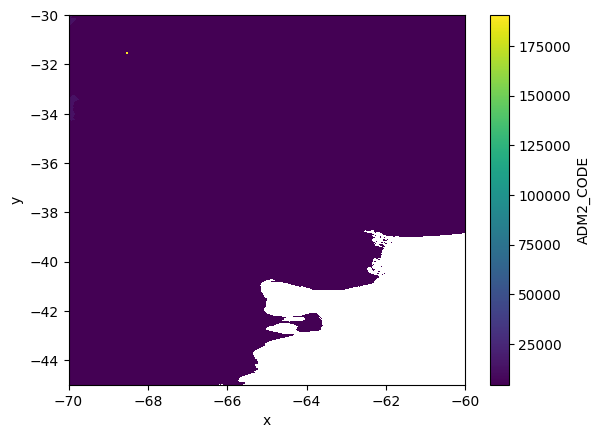

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
adm2.plot()

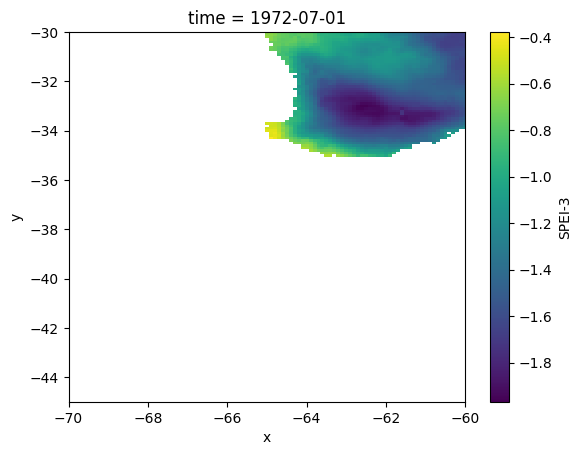

In [36]:
spei3.plot()

In [34]:
spei3.groupby(adm2).mean().to_dataframe()

,time,SPEI-3
ADM2_CODE,,
4379.0,1972-07-01,NaN
4380.0,1972-07-01,NaN
4381.0,1972-07-01,NaN
4382.0,1972-07-01,NaN
4383.0,1972-07-01,NaN
...,...,...
4843.0,1972-07-01,-1.649386
4865.0,1972-07-01,-1.077583
12949.0,1972-07-01,NaN


In [2]:
wb_shp = gpd.read_file(rf"{DATA_RAW}\world_bank_adm2.zip")

In [ ]:
era5 = xr.open_dataset(rf"{DATA_OUT}\ERA5_monthly_1970-2021_SPI-SPEI.nc")
# floods = pd.read_csv(rf"{DATA_RAW}\Floods\GloFAS_floods.csv")

In [ ]:
population = xr.open_dataset(r"Z:\Laboral\World Bank\Vulnerability Index\data\data_in\Grided Population\gpw_v4_population_count_rev11_2020_30_sec.tif") # FIXME: Tendría que usar la del año correspondiente, no la de 2020

In [31]:
# Keep only India from population and floods
min_y = floods.y.min() 
max_y = floods.y.max()
min_x = floods.x.min()
max_x = floods.x.max() 
population = population.sel(y=slice(max_y, min_y), x=slice(min_x,max_x))

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [ ]:
import pandas as pd
from tqdm import tqdm

def compute_share_affected_population(floods, floods_resamp, population):

    import numpy as np
      
    # Calculate affected population for the selected municipality
    population_affected = (floods_resamp * population).sum(dim=('x', 'y'))
    area_affected = (floods).sum(dim=('x', 'y'))

    # Calculate total population for the selected municipality
    total_population = population.sum(dim=('x', 'y'))
    total_area = floods.count(dim=('x', 'y'))
    
    # Calculate share of population affected by floods
    share_population_affected = (population_affected / total_population).band_data.values[0]
    share_area_affected = (area_affected / total_area).band_data.values[0]

    # Return value
    return share_population_affected, share_area_affected

def plot_population_vs_floods(floods, population, polygon):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    floods.rio.clip([polygon]).band_data.plot(ax=ax[0])
    population.rio.clip([polygon]).band_data.plot(ax=ax[1])
    
    return fig, ax
    
# Create emty dataframe to store results

if KIND=="DHS":
    admin_name_col = "ADM2_NAME" # Esto solo si trabajamos con DHS desagregada! FIXME
    admin_code_col = "ADM2_CODE"
    country_map = country_map.dissolve(by="ADM2_CODE").reset_index()
elif KIND=="IPUMS":
    admin_name_col = "ADMIN_NAME"
    admin_code_col = "GEOLEVEL2"

results = pd.DataFrame()    
for i in tqdm(range(0, len(country_map))):
    
    polygon = country_map.geometry[i]

    # Crop xarray to reduce size
    floods_min = crop_xarray_by_poygon(floods, polygon)
    floods_resamp_min = crop_xarray_by_poygon(floods_resamp, polygon)
    population_min = crop_xarray_by_poygon(population, polygon)

    # Clip xarray by poluygon
    floods_min = floods_min.where(create_carray_mask_from_polygon(floods_min, polygon))
    floods_resamp_min = floods_resamp_min.where(create_carray_mask_from_polygon(floods_resamp_min, polygon))
    population_min = population_min.where(create_carray_mask_from_polygon(population_min, polygon))
    
    # plot_population_vs_floods(floods, population, polygon)
    share_pop_affected, share_area_affected = compute_share_affected_population(floods_min, floods_resamp_min, population_min)

    # add to dataframe
    results.loc[i, admin_name_col] = country_map[admin_name_col][i]
    results.loc[i, admin_code_col] = country_map[admin_code_col][i]
    results.loc[i, "POP_PERCENT_AFFECTED"] = share_pop_affected * 100
    results.loc[i, "AREA_PERCENT_AFFECTED"] = share_area_affected * 100
    
results

100%|██████████| 642/642 [06:47<00:00,  1.58it/s]


,ADM2_NAME,ADM2_CODE,POP_PERCENT_AFFECTED,AREA_PERCENT_AFFECTED
0,Andaman Islands,17545.0,0.0,0.000000
1,Nicobar Islands,17546.0,0.0,0.000000
2,Adilabad,17547.0,0.0,0.000000
3,Anantapur,17548.0,0.0,0.000000
4,Chittoor,17549.0,0.0,0.000000
...,...,...,...,...
637,Administrative unit not available,72847.0,0.0,0.032487
638,Administrative unit not available,72848.0,0.0,0.000000
639,Administrative unit not available,72849.0,0.0,0.000000
640,Administrative unit not available,72850.0,0.0,0.000000


In [ ]:
import xarray as xr

# Assuming your geodataframe's geometry column is called 'geometry'
def vectorized_calculation(floods_min, floods_resamp_min, population_min, geometry):
  # 1. Use xr.apply_ufunc with a custom function for municipality-wise calculation
  def calculate_per_municipality(data_array, geom):
    population_affected = (data_array * population_min.where(geom)).sum(dim=('x', 'y'))
    area_affected = (data_array.where(geom)).sum(dim=('x', 'y'))
    total_population = population_min.where(geom).sum(dim=('x', 'y'))
    total_area = data_array.where(geom).count(dim=('x', 'y'))

    share_population_affected = (population_affected / total_population).data[0]
    share_area_affected = (area_affected / total_area).data[0]
    return share_population_affected, share_area_affected

  # 2. Apply the function along the geometry dimension with vectorized operations
  results = xr.apply_ufunc(calculate_per_municipality, floods_resamp_min, geometry, vectorize=True)

  return results

# Call the function with the geodataframe geometry
share_pop_affected, share_area_affected = vectorized_calculation(floods_min, floods_resamp_min, population_min, country_map.geometry)

In [ ]:
import pandas as pd
pd.options.plotting.backend = "plotly"

results.PERCENT_AFFECTED.plot()

AttributeError: 'DataFrame' object has no attribute 'PERCENT_AFFECTED'

In [ ]:
# population.to_netcdf("pop_india.nc")ds.rio.write_crs("epsg:4326", inplace=True)
floods_resamp = floods_resamp.sortby(["y", "x", "band"])
floods_resamp.rio.write_crs("epsg:4326")
floods_resamp.band_data.rio.to_raster("floods_india.tif")

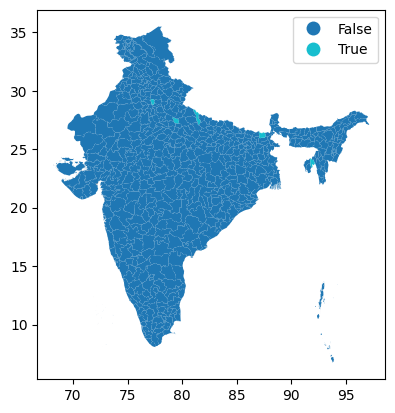

In [ ]:
def plot_treatment(india_map, results):
    
    india_map.merge(results, on="ADM2_CODE", how="inner").plot(column="TREATED", legend=True)
    
    return

plot_treatment(country_map, results)